# NLP with Disaster Tweets

## Problem and Data Description

The goal of this Kaggle competition is to build a model that can classify whether a tweet is about a real disaster (1) or not (0). This is a binary classification problem in the domain of Natural Language Processing (NLP).

Dataset Overview:

Train.csv – 7,613 tweets with labeled targets.

Test.csv – 3,263 tweets to classify for submission.

Sample_submission.csv – Format for submission file.

Key Columns in train.csv:

id: Unique identifier

keyword: Optional keyword from the tweet

location: Optional location of the tweet

text: The tweet itself (main feature)

target: 1 if the tweet is about a real disaster, 0 otherwise (label)

## Load Libraries

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk
import re
from wordcloud import WordCloud

import string
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN, GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Load Data

In [3]:
df = pd.read_csv('train.csv')

In [4]:
print("Shape of dataset:", df.shape)
print("\nData types and missing values:\n", df.info())

Shape of dataset: (7613, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

Data types and missing values:
 None


In [5]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## EDA

### Class Distribution

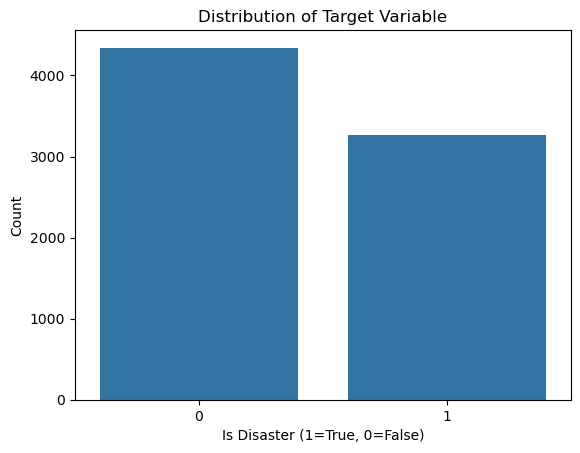

Percentage of disaster tweets: 42.96597924602653


In [6]:
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Is Disaster (1=True, 0=False)')
plt.ylabel('Count')
plt.show()

print("Percentage of disaster tweets:", df['target'].mean() * 100)

As we can see, there is a slight imbalance with the dataset with about 43% of tweets being classified as disaster related and 57% percent of tweets being classified as non-disaster related. We will handle this imbalance later in the notebook. Next, we will check for missing values.

### Missing Values

In [7]:
print(df.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


Since the location variable has 2,533 missing values (more than 1/3 of the total dataset), I will remove that variable rather than trying to encode the missing values. Next, I will remove all observations that have missing values since the only other variable that has missing values is the keyword variable with 61 missing values which is less than 1% of the total dataset.

In [8]:
df = df.drop(columns=['location'])

In [9]:
df = df.dropna()

In [10]:
print(df.isnull().sum())

id         0
keyword    0
text       0
target     0
dtype: int64


### Length of Tweets

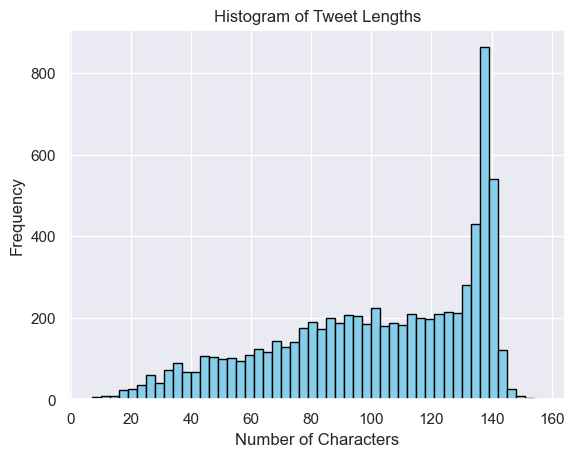

In [12]:
df['text_len'] = df['text'].apply(len)

# Histogram of tweet lengths
plt.hist(df['text_len'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Tweet Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

Based on the distribution of the length of tweets, we can see that it is skewed to the left and that the mode of the number of characters in each tweet is around 140. This leads me to assume that most of these tweets were taken from before November 2017 because prior to this date, Twitter had a maximum tweet length of 140. Therefore, I believe that most people were trying to fit as many characters into their tweets as possible.

### Clean Text

In [17]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URLs
    text = re.sub(r'<.*?>', '', text)  # remove HTML
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned_text'] = df['text'].apply(clean_text)
df[['text', 'cleaned_text']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zachk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,text,cleaned_text
31,@bbcmtd Wholesale Markets ablaze http://t.co/l...,bbcmtd wholesale markets ablaze
32,We always try to bring the heavy. #metal #RT h...,always try bring heavy metal rt
33,#AFRICANBAZE: Breaking news:Nigeria flag set a...,africanbaze breaking newsnigeria flag set abla...
34,Crying out for more! Set me ablaze,crying set ablaze
35,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,plus side look sky last night ablaze


### Visualize Common Words and Keywords

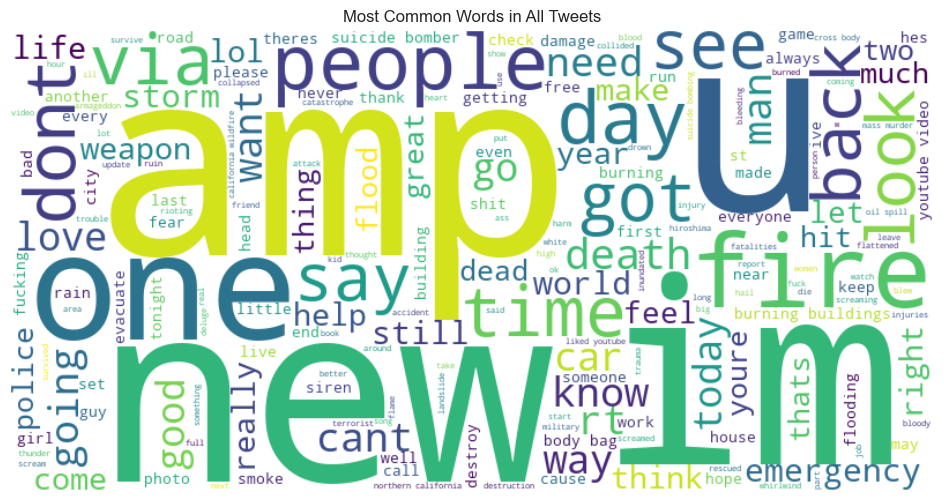

In [18]:
# Join all cleaned text into a single string
all_words = ' '.join(df['cleaned_text'])

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in All Tweets')
plt.show()

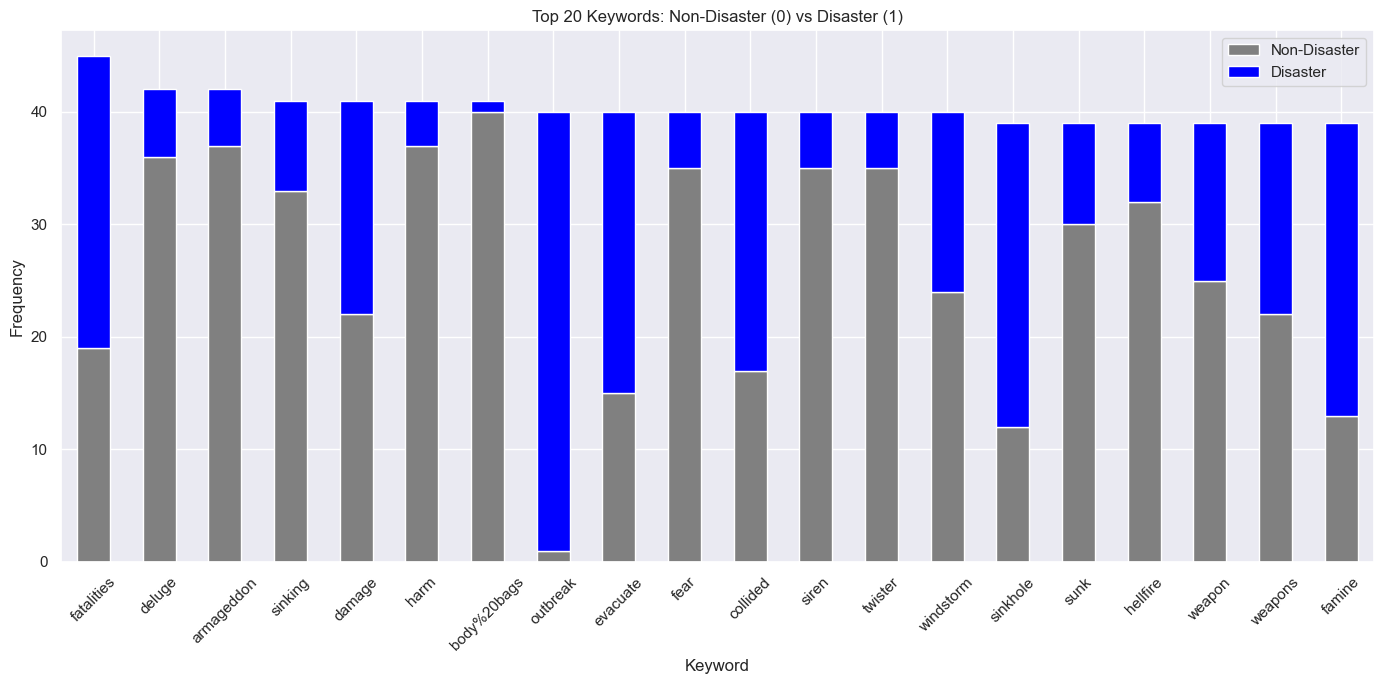

In [21]:
# group by keyword and target
top_keywords = df_keywords.groupby(['keyword', 'target']).size().unstack(fill_value=0)

# sort by total frequency
top_keywords['total'] = top_keywords[0] + top_keywords[1]
top_keywords = top_keywords.sort_values('total', ascending=False).head(20)

top_keywords[[0, 1]].plot(kind='bar', stacked=True, figsize=(14, 7), color=['gray', 'blue'])
plt.title('Top 20 Keywords: Non-Disaster (0) vs Disaster (1)')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(['Non-Disaster', 'Disaster'])
plt.tight_layout()
plt.show()

The top 3 disaster-related keywords are "outbreak", "sinkhole", and "famine". This makes sense as all of these words are related to natural disasters. The top 3 non-disaster-related keywords are "bodybags", "harm", and "armageddon". This leads me to believe that most of these words are probably used in the context of some type of threat towards an individual or a group of individuals. For example, I believe that armageddon is used to represent a type of biblical "end of the world".

## Text Preprocessing

We will use the pre-trained GloVe word vector from Twitter.

In [25]:
embedding_index = {}
with open('glove.twitter.27B.200d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

In [33]:
# prepare tokenizer
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_text'])

# convert to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# pad sequences to same length
padded_sequences = pad_sequences(sequences, maxlen=100)

In [35]:
word_index = tokenizer.word_index
embedding_dim = 200
num_words = min(20000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Model Building

In [38]:
labels = df['target'].values

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [39]:
model = Sequential()
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=100,
                    trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\zachk\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,347,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,347,200 (12.77 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,347,200 (12.77 MB)

In [42]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=64)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9429 - loss: 0.1466 - val_accuracy: 0.7836 - val_loss: 0.7512
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9520 - loss: 0.1262 - val_accuracy: 0.7809 - val_loss: 0.8067
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9576 - loss: 0.1144 - val_accuracy: 0.7889 - val_loss: 0.9405
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9626 - loss: 0.1009 - val_accuracy: 0.7743 - val_loss: 0.9508
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9606 - loss: 0.0961 - val_accuracy: 0.7935 - val_loss: 0.9770
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9589 - loss: 0.1022 - val_accuracy: 0.7829 - val_loss: 1.0250
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9694 - loss: 0.0831 - val_accuracy: 0.7975 - val_loss: 1.0433
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9730 - loss: 0.0721 - val_accuracy: 0.7790 - v

## Model Comparison and Hyperparamater Tuning

In [44]:
def build_model(rnn_type='LSTM', bidirectional=False, units=64, dropout_rate=0.5):
    model = Sequential()
    model.add(Embedding(input_dim=num_words,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=100,
                        trainable=False))
    
    RNNLayer = {'SimpleRNN': SimpleRNN, 'GRU': GRU, 'LSTM': LSTM}[rnn_type]
    
    if bidirectional:
        model.add(Bidirectional(RNNLayer(units)))
    else:
        model.add(RNNLayer(units))
        
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [46]:
configs = [
    {'rnn_type': 'SimpleRNN', 'bidirectional': False, 'label': 'Simple RNN'},
    {'rnn_type': 'GRU',       'bidirectional': False, 'label': 'GRU'},
    {'rnn_type': 'LSTM',      'bidirectional': True,  'label': 'Bidirectional LSTM'},
]

results = []

for cfg in configs:
    print(f"\nTraining: {cfg['label']}")
    model = build_model(rnn_type=cfg['rnn_type'], bidirectional=cfg['bidirectional'])

    es = EarlyStopping(patience=2, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=20, batch_size=64, callbacks=[es], verbose=1)
    
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    results.append((cfg['label'], val_acc, model))


Training: Simple RNN
Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5870 - loss: 0.6948 - val_accuracy: 0.7942 - val_loss: 0.4735
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7928 - loss: 0.4676 - val_accuracy: 0.8054 - val_loss: 0.4579
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8090 - loss: 0.4426 - val_accuracy: 0.8068 - val_loss: 0.4547
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8256 - loss: 0.4176 - val_accuracy: 0.8114 - val_loss: 0.4534
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8274 - loss: 0.4096 - val_accuracy: 0.7995 - val_loss: 0.4587
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8386 - loss: 0.3957 - val_accuracy: 0.7995 - val_loss: 0.4619

Training: GRU
Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6575 - loss: 0.6089 - val_accuracy: 0.7915 - val_loss: 0.4525
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8149 - loss: 


Best model: Simple RNN with validation accuracy: 0.8114
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.84       874
           1       0.82      0.71      0.76       637

    accuracy                           0.81      1511
   macro avg       0.81      0.80      0.80      1511
weighted avg       0.81      0.81      0.81      1511



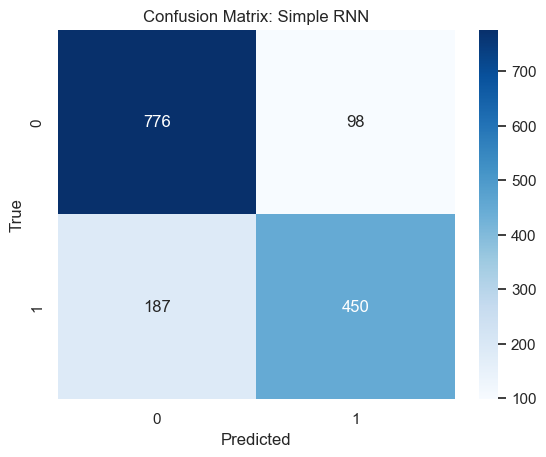

In [48]:
# best model
best_model_name, best_acc, best_model = sorted(results, key=lambda x: x[1], reverse=True)[0]
print(f"\nBest model: {best_model_name} with validation accuracy: {best_acc:.4f}")

y_pred_probs = best_model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.show()

## Submission

In [49]:
test_df = pd.read_csv('test.csv')

# Use the same cleaning function
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Convert to sequences and pad
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])
test_padded = pad_sequences(test_sequences, maxlen=100)

In [50]:
test_preds = best_model.predict(test_padded)
test_labels = (test_preds > 0.5).astype(int).flatten()

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [51]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_labels.astype(int)
})

submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [52]:
submission.to_csv('submission.csv', index=False)

## Conclusion

In this project, I explored multiple RNN-based architectures to classify tweets as either disaster-related or not. Among the models tested — Simple RNN, GRU, and Bidirectional LSTM — the Simple RNN model surprisingly achieved the highest validation accuracy at 81.1%.

The classification report and confusion matrix revealed that the model performed better on predicting non-disaster tweets (class 0) than disaster-related ones (class 1). Specifically, the model had a higher recall for class 0 (0.89) compared to class 1 (0.71), suggesting that it was more confident in identifying non-disasters but missed a substantial number of true disaster tweets (187 false negatives).

What Helped:
Pre-trained GloVe Twitter embeddings provided meaningful representations tailored to short, informal text like tweets. Dropout and early stopping helped reduce overfitting, especially on the deeper models like Bidirectional LSTM.

What Didn’t Help: More complex models like GRU and Bidirectional LSTM did not outperform the Simple RNN, potentially due to overfitting on the small dataset or lack of significant long-term dependencies in the tweet text. The location and keyword fields did not add much predictive power and were excluded from the final model.

## Future Work

Data augmentation (e.g., back translation, synonym replacement) could help increase the diversity and size of the training data.

Ensemble methods (combining predictions from multiple models) might improve performance by balancing precision and recall.

Trying transformer-based models like BERT, which have been highly successful in NLP tasks, could significantly boost performance, especially in identifying nuanced tweet content.

Further hyperparameter tuning (e.g., learning rate, batch size, number of units) and deeper architecture exploration could lead to incremental improvements.